<a href="https://colab.research.google.com/github/TONMOY1904034/Brain_tumor_detection_project/blob/main/DENSENET169_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import random
from PIL import Image,ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from sklearn.utils import shuffle

In [ ]:
train='/content/drive/MyDrive/MRI/Training'
test='/content/drive/MyDrive/MRI/Testing'

train_paths=[]
train_labels=[]

for label in os.listdir(train):
  for image in os.listdir(os.path.join(train,label)):
    train_paths.append(os.path.join(train,label,image))
    train_labels.append(label)
    train_paths,train_labels=shuffle(train_paths,train_labels)

    test_paths=[]
test_labels=[]

for label in os.listdir(test):
  for image in os.listdir(os.path.join(test,label)):
    test_paths.append(os.path.join(test,label,image))
    test_labels.append(label)
    test_paths,test_labels=shuffle(test_paths,test_labels)


In [ ]:
# ... (previous code) ...

# Create validation dataset
# Assuming you want to use 20% of the training data for validation
val_split = 0.2
num_val_samples = int(len(train_paths) * val_split)

# Split the training data into training and validation sets
val_paths = train_paths[:num_val_samples]
val_labels = train_labels[:num_val_samples]
train_paths = train_paths[num_val_samples:]
train_labels = train_labels[num_val_samples:]

# ... (rest of the code) ...

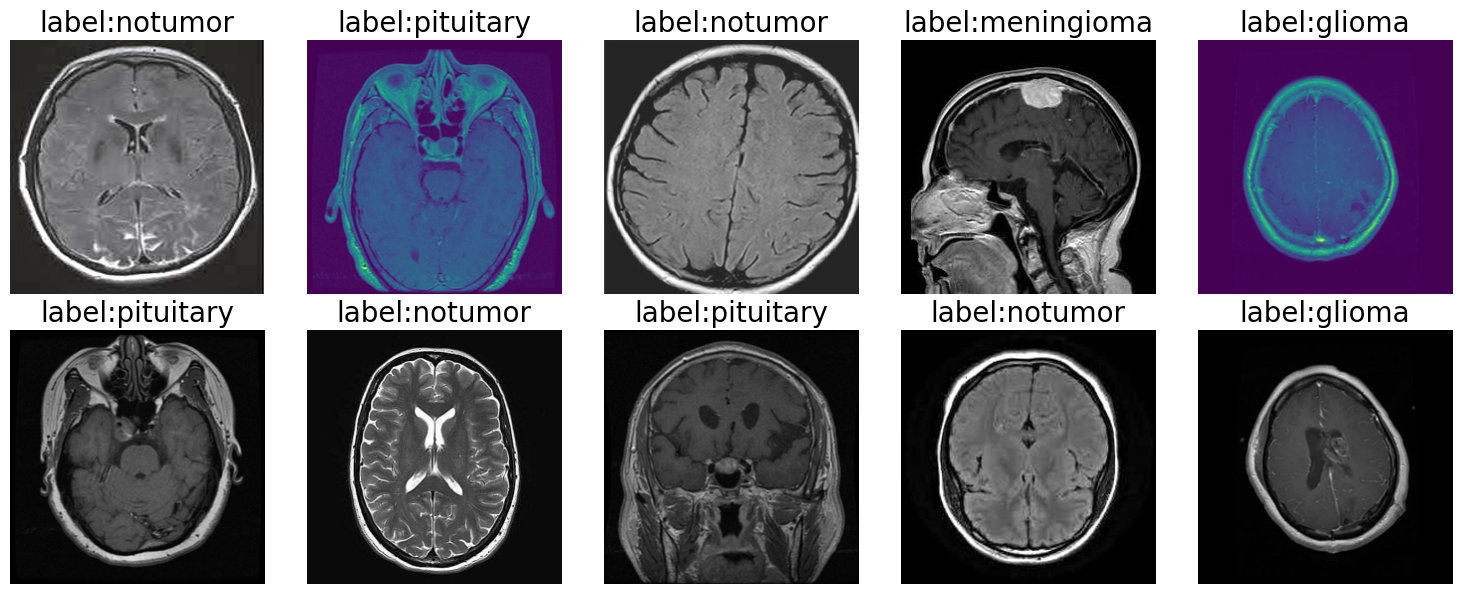

In [ ]:
random_indices=random.sample(range(len(train_paths)),10)
random_indices
fig,axes=plt.subplots(2,5,figsize=(15,6))
axes=axes.ravel( )

for i,idx in enumerate(random_indices):
    # The following lines need to be indented to be part of the for loop
    img_path = train_paths[idx]
    img=Image.open(img_path)
    img=img.resize((256,256))

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"label:{train_labels[idx]}",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on  requirements)
base_model = DenseNet169(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 50

# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    steps_per_epoch=steps,
    epochs=epochs,
    validation_data=datagen(val_paths, val_labels, batch_size=batch_size)

)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - loss: 0.7534 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.3032 - val_sparse_categorical_accuracy: 0.8958
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


228/228 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - loss: 0.2814 - sparse_categorical_accuracy: 0.8953 - val_loss: 0.3055 - val_sparse_categorical_accuracy: 0.9250
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - loss: 0.2037 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.3074 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.3210 - val_sparse_categorical_accuracy: 0.9500
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - loss: 0.0898 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.2681 - val_sparse_categorical_accuracy: 0.9500
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.3228 - val_sparse_categorical_accuracy: 0.9250
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.2460 - val_sparse_categorical_accuracy: 0.9500
Epoch 8/5

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(open_images(test_paths))  # Use open_images to preprocess test images
predicted_labels = np.argmax(test_predictions, axis=1)


# 2. Classification Report
print("Classification Report:")
report = classification_report(test_labels_encoded, predicted_labels, target_names=os.listdir(train))  # Use target_names for label names
print(report)

41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.91      0.94       300
  meningioma       0.89      0.95      0.92       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.99      0.95      0.97       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.96      1311



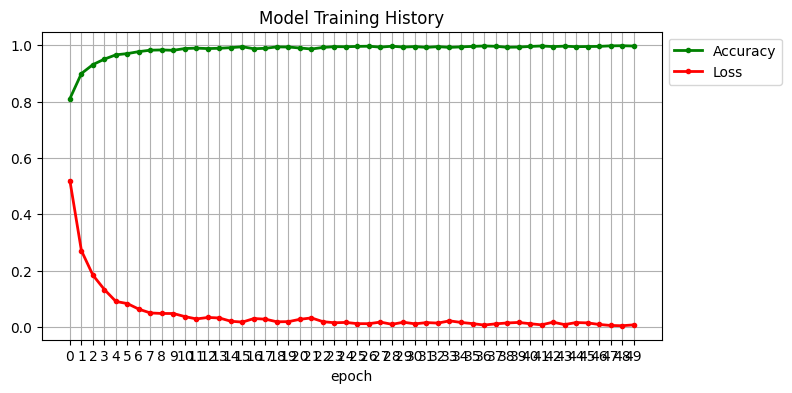

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'model' is your trained Keras model
# Assuming 'test_paths' are the paths to your test images
# Assuming 'test_labels' are the corresponding true labels for the test images

# 1. Make predictions
test_predictions = model.predict(open_images(test_paths))  # Use open_images to preprocess test images
predicted_labels = np.argmax(test_predictions, axis=1)

# 2. Encode true labels if necessary
# If test_labels are not already encoded, encode them using your encode_label function
test_labels_encoded = encode_label(test_labels)

# 3. Generate and print the classification report
report = classification_report(test_labels_encoded, predicted_labels, target_names=os.listdir(train))  # Use target_names for label names
print(report)


41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.91      0.94      0.92       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.99      0.96      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



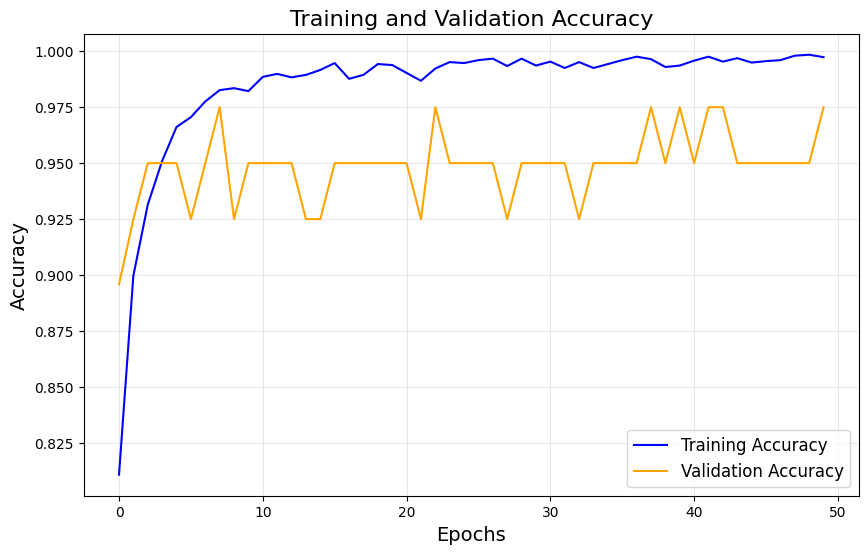

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy', color='orange')

# Add labels, title, and legend
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.3)

# Show the plot
plt.show()

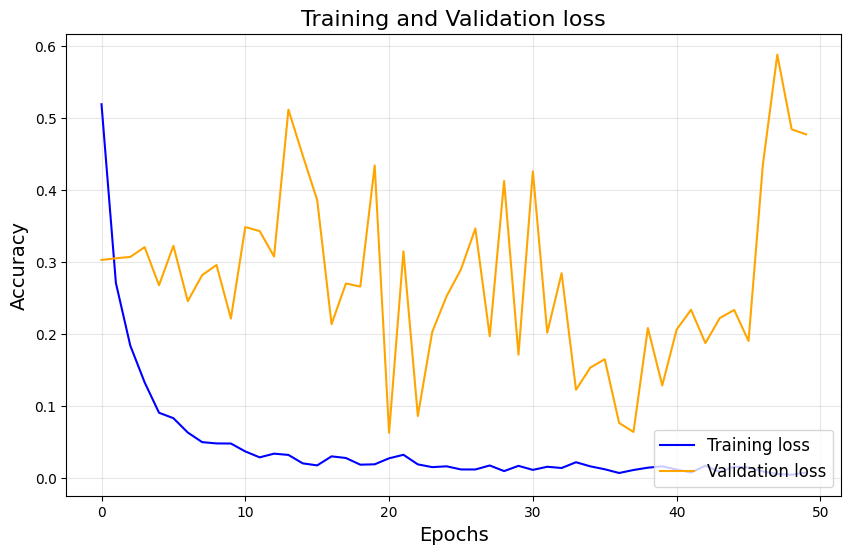

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation loss', color='orange')

# Add labels, title, and legend
plt.title('Training and Validation loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.3)

# Show the plot
plt.show()

Confusion Matrix:
[[279  20   0   1]
 [  3 288  13   2]
 [  3   0 402   0]
 [  2   9   2 287]]


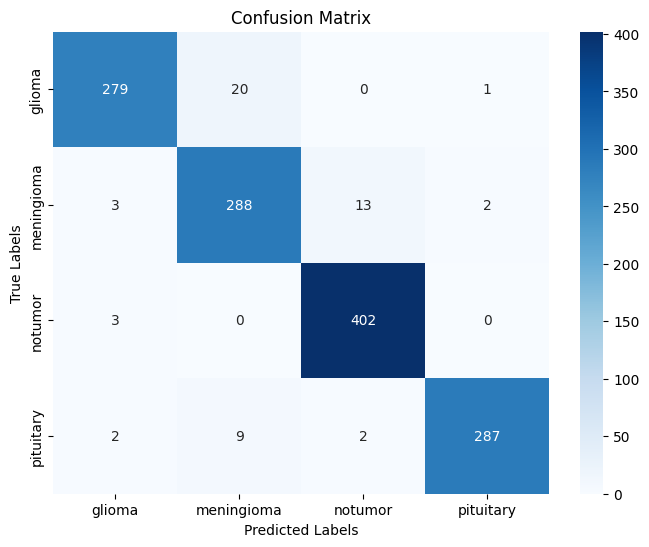

In [ ]:
# 3. Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train), yticklabels=os.listdir(train))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

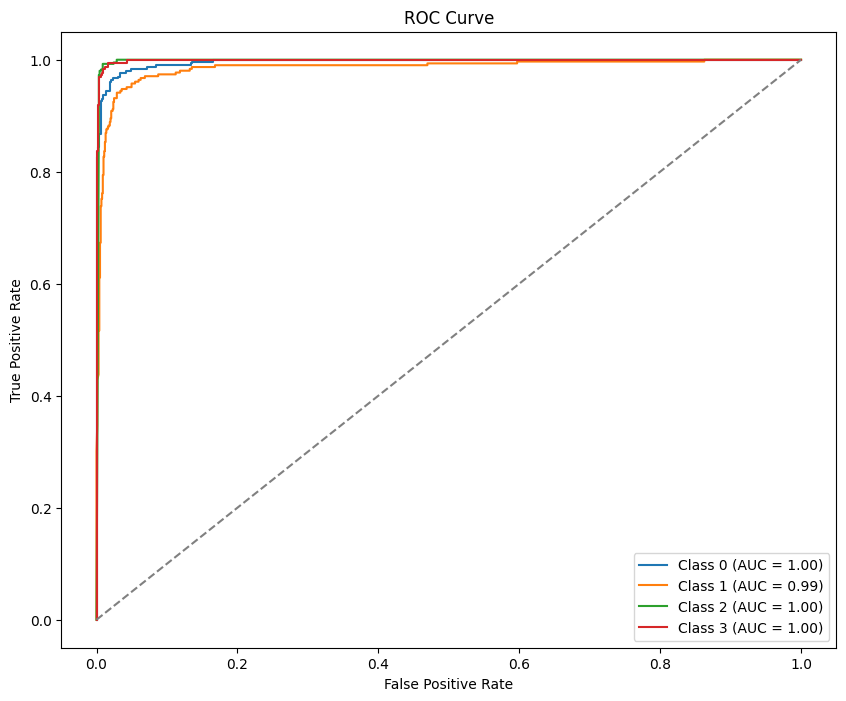

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the entire model
model.save('model.h5')
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


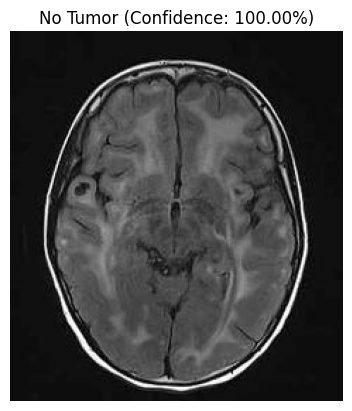

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI/Testing/notumor/Te-no_0019.jpg'
detect_and_display(image_path, model)